In [1]:
%load_ext tensorboard

import torch
from torch import nn
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms as T
import timm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adapted from https://github.com/tjmoon0104/pytorch-tiny-imagenet/blob/master/AlexNet.ipynb
data_transforms = {
    'train': T.Compose([
        T.Resize(299), T.ToTensor(),
    ]),
    'val': T.Compose([
        T.Resize(299), T.ToTensor(),
    ]),
    'test': T.Compose([
        T.Resize(299), T.ToTensor(),
    ])
}

data_dir = "C:\\Users\\Gabriel\\Documents\\Winter2022\\CIS472\\Project\\tiny-imagenet-200"
num_workers = {
    'train' : 4,
    'val'   : 0,
    'test'  : 0
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             num_workers=num_workers[x], shuffle=True)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

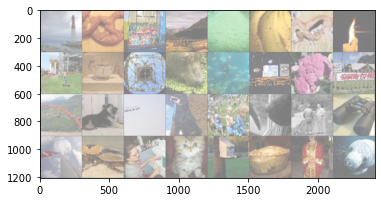

In [3]:
#
# Adapted from Stephen's ModelExamples
#
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
train = dataloaders["train"]

dataiter = iter(train)
imgs, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(imgs)
imgs, labels = imgs.to(device), labels.to(device)
matplotlib_imshow(img_grid)

In [24]:
# Credit https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.empty(tensor.size(), device=device).normal_() * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    

class RobustInception(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        # Modify the last fully connected layer
        bare_inception = torchvision.models.inception_v3(pretrained=True, aux_logits=False)
        bare_inception.fc.out_features = 200
        bare_inception
        # Incoporate in model, probability softmax incorportated into loss
        self.inception = bare_inception
        self.perturb = AddGaussianNoise(0, 0.05)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return torch.cat((self.inception(x), self.inception(self.perturb(x))), 1)

In [27]:
ALPHA = 0.01

training_objective = nn.CrossEntropyLoss()

stability_loss = nn.CrossEntropyLoss()

def full_loss(outputs, label):
    clean_output, distort_output = torch.split(outputs, 1000, 1)
    return training_objective(clean_output, label) + ALPHA * stability_loss(distort_output, clean_output)

In [5]:
model = RobustInception().to(device)